Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# Ask the Graph
# Notebook 2: Ingest Structured and Unstructured Data: Neptune and OpenSearch

In this notebook we ingest into the knowledge graph on Amazon Neptune and a search index/vector store on an Amazon OpenSearch Service domain. We ingest data prepared in notebooks 0 and 1. You do NOT need to run notebooks 0 and 1. We have prepared the data for you. It is available here: 

- s3://aws-neptune-customer-samples/tmls2024/source/ - source rdf files to load to Neptune
- s3://aws-neptune-customer-samples/tmls2024/aos/ - Chunk embeddings to load to OpenSearch
- s3://aws-neptune-customer-samples/tmls2024/graphdata/ - RDF files to load to Neptune
- s3://aws-neptune-customer-samples/tmls2024/documents/ - Press release documents as text files.
- s3://aws-neptune-customer-samples/tmls2024/chunks/ - Chunks of press release documents as text files.

Here is our data model. This notebook prepares the unstructured sources (red boxes, upper third) and extracted facts (yellow boxes, middle third).

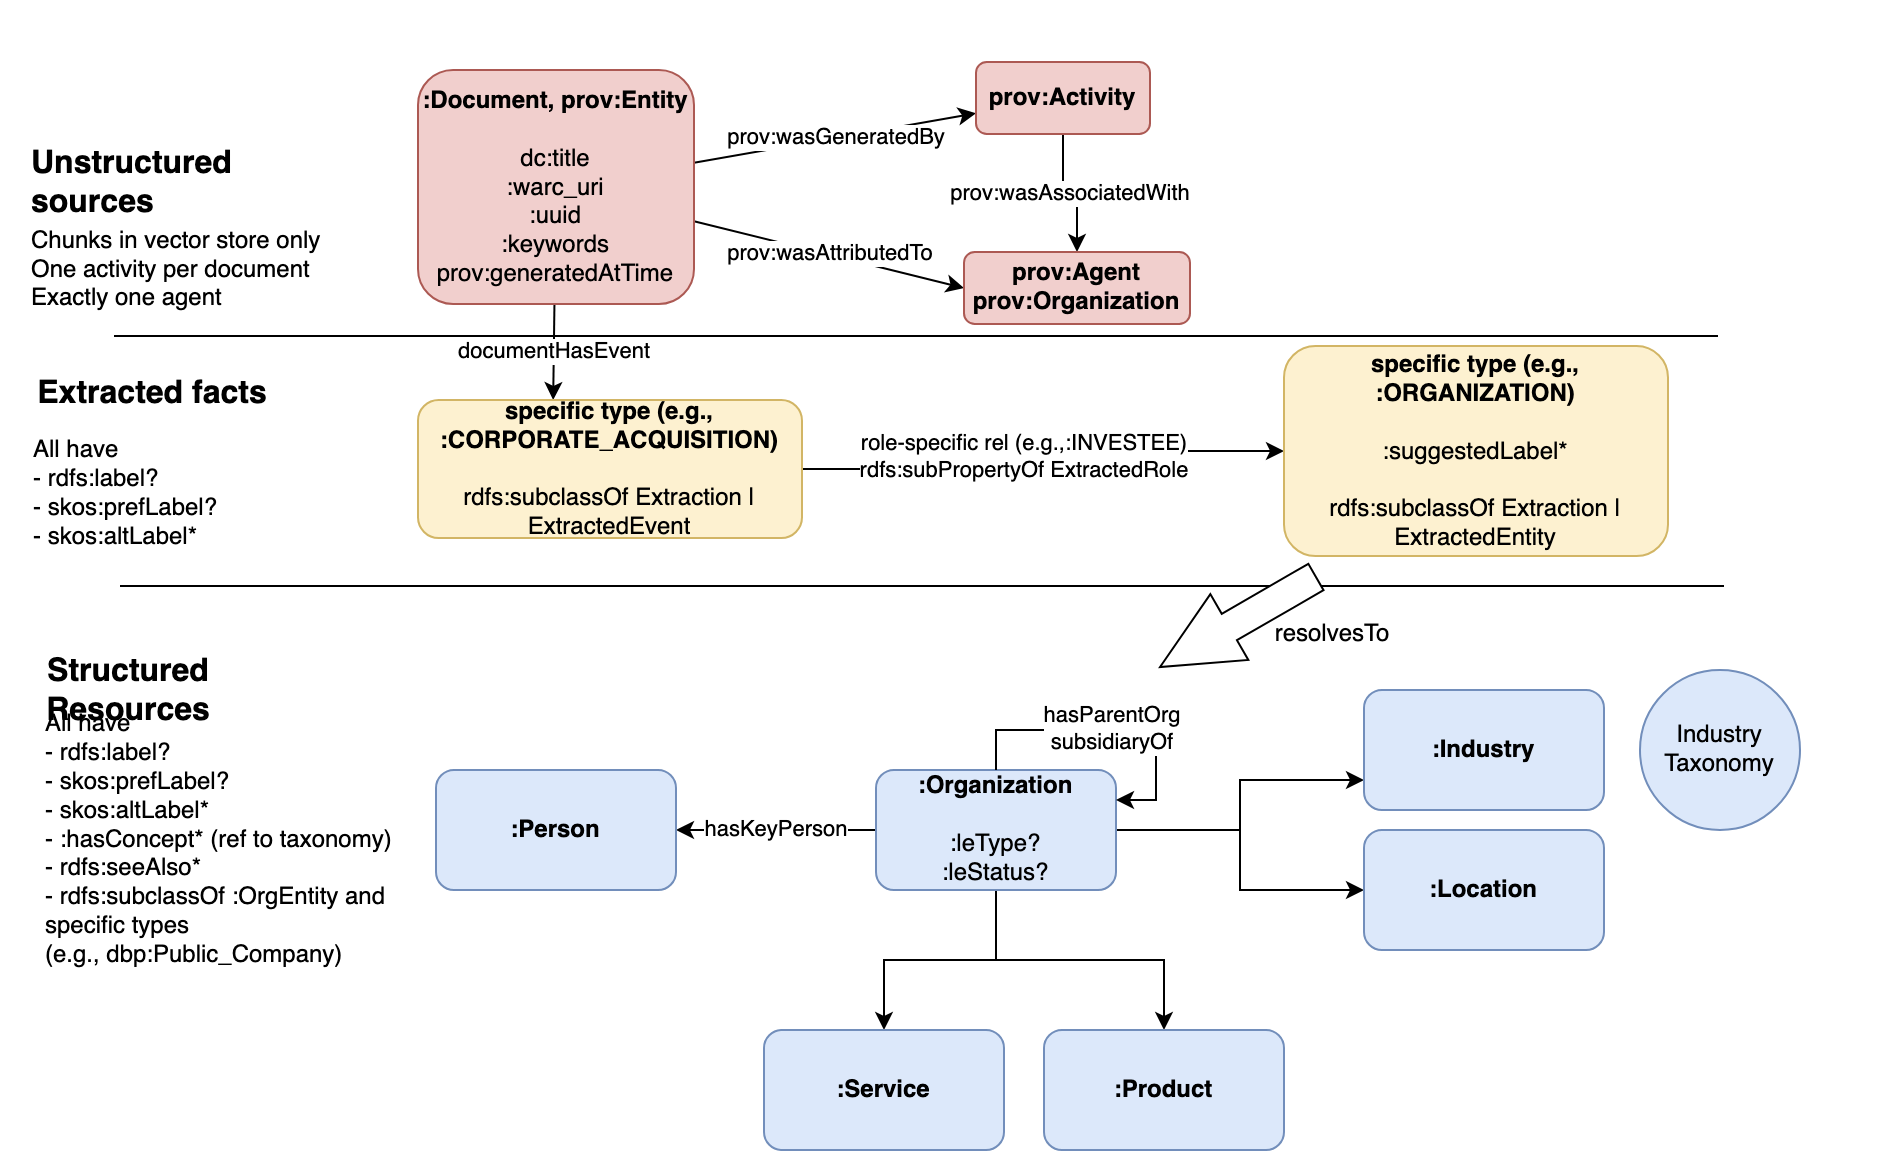

The next diagram shows data ingest:

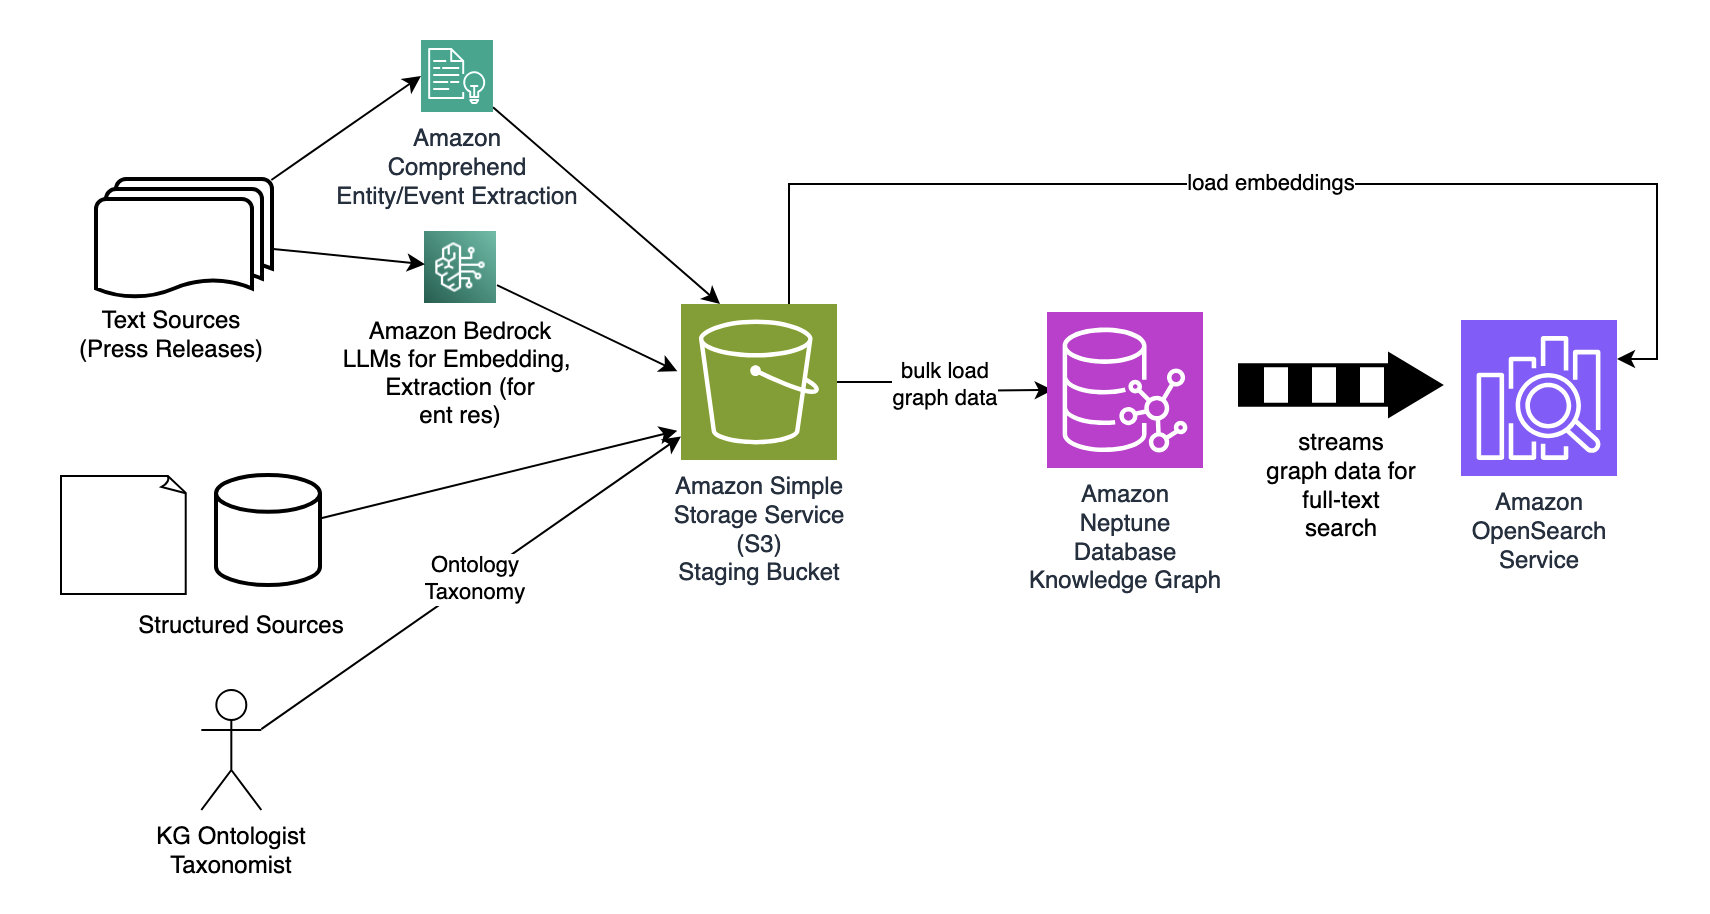

We assume you have a Neptune cluster, an OpenSearch Service domain, an S3 staging bucket, full-text search setup to stream Neptune updates to OpenSearch. Additionally, the notebook instance must have S3, Bedrock, Neptune, and OpenSearch permissions, as well as connectivity to Neptune and OpenSearch. Refer to the README for setup instructions.

## Install a few dependencies


In [ ]:
!pip install -q opensearch-py

In [ ]:
!pip install -U langchain-community

## Get source data

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/tmls2024/aos/ aos

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/tmls2024/graphdata graphdata

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/tmls2024/source source

## Initialize

In [ ]:
import aos_helpers as aosh

AOS_ENDPOINT_HOST="<your AOS endpoint host>"
AOS_ENDPOINT_HOST="vpc-movie-ouest-c7fgwntte7e2mz7ho3u7scqahe.us-west-2.es.amazonaws.com"

aos_client=aosh.connect_aos(AOS_ENDPOINT_HOST)


In [ ]:
aosh.get_indices(aos_client)

## Load Chunk index to opensearch

In [ ]:
#aosh.delete_index(aos_client, aosh.CHUNK_INDEX)
#aosh.delete_index(aos_client, aosh.CHUNK_EMBEDDINGS_INDEX)


In [ ]:
aosh.create_index(aos_client, aosh.CHUNK_INDEX, aosh.CHUNKS_INDEX_DEF)
aosh.create_index(aos_client, aosh.CHUNK_EMBEDDINGS_INDEX, aosh.CHUNK_EMBEDDINGS_INDEX_DEF)


In [ ]:
cret=aosh.load_records_from_file(aos_client, "aos/chunks.jsonl", aosh.CHUNK_INDEX)

In [ ]:
eret=aosh.load_records_from_file(aos_client, "aos/chunk_embeddings.jsonl", aosh.CHUNK_EMBEDDINGS_INDEX)

In [ ]:
import json
with open('cret.json', 'w') as saved: 
    saved.write(json.dumps(cret))
with open('eret.json', 'w') as saved: 
    saved.write(json.dumps(eret))

In [ ]:
aosh.get_index(aos_client, aosh.CHUNK_INDEX)

### Verify with queries

In [ ]:
search_text="Whole foods"
query = {
    "query": {
        "match": {
            "chunk_content": { 
                "query": search_text,
                "fuzziness": "AUTO"
            }
        }
    }
}
ret=aos_client.search(index=aosh.CHUNK_INDEX, body=query)
for h in ret['hits']['hits']:
    print(f"\n\t{h['_id']}|{h['_score']}|{h['_source']['title']}|{h['_source']['chunk_content']}")


In [ ]:
import ai_helpers as aih

search_vector=aih.make_embedding("Amazon buys Ring or Rivian")

query={
    "query": {
        "knn": {
            "embedding":{
                "vector":search_vector,
                "k":30
            }
        }
    }
}

ret=aos_client.search(index=aosh.CHUNK_EMBEDDINGS_INDEX, body=query)
for h in ret['hits']['hits']:
    print(f"\n\t{h['_id']}|{h['_score']}|{h['_source']['title']}|{h['_source']['chunk_content']}")


## Load Neptune data
### Copy to an S3 bucket in your account in the same region

In [ ]:
S3_BUCKET="<your bucket>"
S3_BUCKET_NOSLASH="s3://havey-movie-west/xskg"


In [ ]:
%%bash -s "$S3_BUCKET_NOSLASH"

aws s3 sync graphdata/rdf $1
aws s3 sync source/rdf $1
aws s3 rm $1/.ipynb_checkpoints

### Bulk-load

In [ ]:
%%sparql

delete {?s ?p ?o} where {?s ?p ?o}

In [ ]:
%load -s {S3_BUCKET_NOSLASH} -f turtle -p OVERSUBSCRIBE --store-to result1 --no-fail-on-error --run

In [ ]:
%load_status {result1['payload']['loadId']} --details --errors

### Verify with queries

In [ ]:
%%sparql

PREFIX ns1: <http://example.org/orgdemo/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

select * where {
    ?s rdf:type/rdfs:subClassOf ns1:OrgEntity .
    ?s a ?t .
} LIMIT 100


In [ ]:
%%sparql

PREFIX : <http://example.org/orgdemo/> 
PREFIX ev: <http://example.org/orgdemo/xev> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 

select * where {
    ?ent :resolvesTo ?blue .
    ?blue rdf:type/rdfs:subClassOf :OrgEntity .
    ?doc :documentHasEvent ?ev .
    ?role rdfs:subPropertyOf :ExtractedRole .
    ?ev ?role ?ent .
} LIMIT 100


### Verify FTS results in OpenSearch

In [ ]:
aosh.get_index(aos_client, "amazon_neptune")

In [ ]:
search_text="aws"
query = {
    "size": 40,
    "query": {
        "match_all": {}
    }
}
ret=aos_client.search(index="amazon_neptune", body=query)
ret